# Q5: Analysis (20 points)
By now you should know how to train networks from scratch or using from pre-trained models. You should also understand the relative performance in either scenarios. Needless to say, the performance of these models is stronger than previous non-deep architectures used until 2012. However, final performance is not the only metric we care about. It is important to get some intuition of what these models are really learning. Lets try some standard techniques.


**FEEL FREE TO WRITE UTIL CODE IN ANOTHER FILE AND IMPORT IN THIS NOTEBOOK FOR EASE OF READABILITY**

## 5.1 Nearest Neighbors (7 pts)
Pick 3 images from PASCAL test set from different classes, and compute 4 nearest neighbors of those images over the test set. You should use and compare the following feature representations for the nearest neighbors:
1. fc7 features from the ResNet (finetuned from ImageNet)
2. pool5 features from the CaffeNet (trained from scratch)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
%matplotlib inline

import trainer
import utils
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset
from sklearn.neighbors import NearestNeighbors
import numpy as np


class CaffeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(256 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 20)
        self.dropout = nn.Dropout(p=0.5) 
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        flat_x = x.view(-1, 256 * 5 * 5)
        out = self.fc1(flat_x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return flat_x

resnet = models.resnet18(pretrained=True)
truncated_model = list(resnet.children())[:-1]
resnet = nn.Sequential(*truncated_model)
for p in resnet:
    p.requires_grad = False

In [2]:
# load images, calculate nearest neighbors, and plot
model = CaffeNet().to('cuda')
model.load_state_dict(torch.load("models/q2_50"))
model.eval()

test_loader = utils.get_data_loader('voc', train=False, batch_size=32, split='test')
all_features = None
all_data = None

for batch_idx, (data, target, wgt) in enumerate(test_loader):
    # Get a batch of data
    data, target, wgt = data.to('cuda'), target.to('cuda'), wgt.to('cuda')
    output = model(data)
    if all_features is None:
        all_features = output.detach().cpu().numpy()
    else:
        all_features = np.concatenate((all_features, output.detach().cpu().numpy()), axis=0)
    if all_data is None:
        all_data = data.detach().cpu().numpy()
    else:
        all_data = np.concatenate((all_data, data.detach().cpu().numpy()), axis=0)

        
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(all_features)
distances0, indices0 = nbrs.kneighbors(all_features[0, :].reshape((1, -1)))
distances1, indices1 = nbrs.kneighbors(all_features[1, :].reshape((1, -1)))
distances2, indices2 = nbrs.kneighbors(all_features[2, :].reshape((1, -1)))

CaffeNet

The leftmost image is the picked image, the other 4 is its nearest neighbors


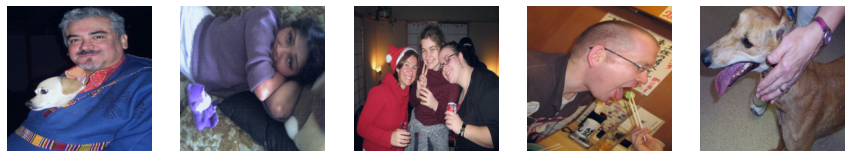

The leftmost image is the picked image, the other 4 is its nearest neighbors


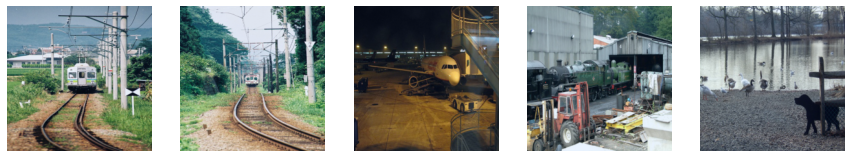

The leftmost image is the picked image, the other 4 is its nearest neighbors


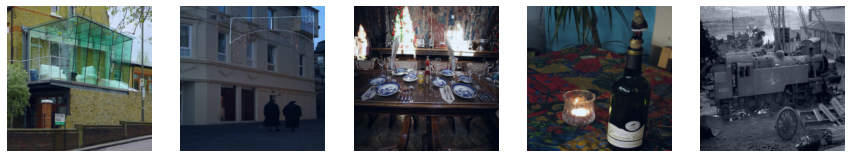

In [3]:
print("CaffeNet\n")

print("The leftmost image is the picked image, the other 4 is its nearest neighbors")
fig0, ax0 = plt.subplots(1, 5)
fig0.set_figwidth(15)
for i, index in enumerate(indices0[0]):
    image = np.moveaxis(all_data[index], 0, -1)
    image = (image - image.min()) / (image.max() - image.min())
    ax0[i].axis("off")
    ax0[i].imshow(image)
plt.show()

print("The leftmost image is the picked image, the other 4 is its nearest neighbors")
fig1, ax1 = plt.subplots(1, 5)
fig1.set_figwidth(15)
for i, index in enumerate(indices1[0]):
    image = np.moveaxis(all_data[index], 0, -1)
    image = (image - image.min()) / (image.max() - image.min())
    ax1[i].axis("off")
    ax1[i].imshow(image)
plt.show()

print("The leftmost image is the picked image, the other 4 is its nearest neighbors")
fig2, ax2 = plt.subplots(1, 5)
fig2.set_figwidth(15)
for i, index in enumerate(indices2[0]):
    image = np.moveaxis(all_data[index], 0, -1)
    image = (image - image.min()) / (image.max() - image.min())
    ax2[i].axis("off")
    ax2[i].imshow(image)
plt.show()

In [4]:
# load images, calculate nearest neighbors, and plot
model = resnet.to('cuda')
model.eval()

test_loader = utils.get_data_loader('voc', train=False, batch_size=32, split='test')
all_features = None
all_data = None

for batch_idx, (data, target, wgt) in enumerate(test_loader):
    # Get a batch of data
    data, target, wgt = data.to('cuda'), target.to('cuda'), wgt.to('cuda')
    output = model(data)
    if all_features is None:
        all_features = output.detach().cpu().numpy().reshape((data.shape[0], -1))
    else:
        all_features = np.concatenate((all_features, 
                                       output.detach().cpu().numpy().reshape((data.shape[0], -1))), axis=0)
    if all_data is None:
        all_data = data.detach().cpu().numpy()
    else:
        all_data = np.concatenate((all_data, data.detach().cpu().numpy()), axis=0)
    
        
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(all_features)
distances0, indices0 = nbrs.kneighbors(all_features[0, :].reshape((1, -1)))
distances1, indices1 = nbrs.kneighbors(all_features[1, :].reshape((1, -1)))
distances2, indices2 = nbrs.kneighbors(all_features[2, :].reshape((1, -1)))

ResNet

The leftmost image is the picked image, the other 4 is its nearest neighbors


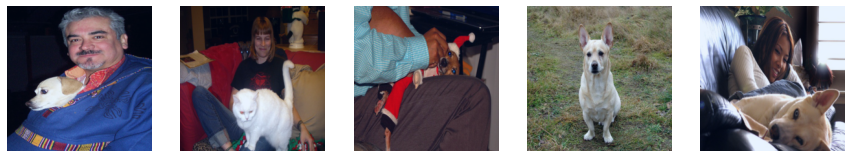

The leftmost image is the picked image, the other 4 is its nearest neighbors


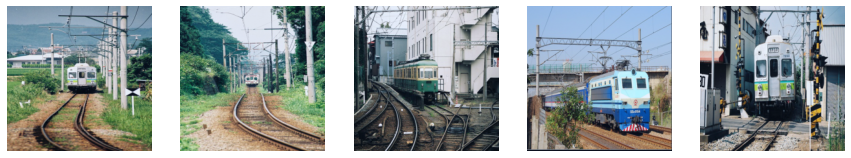

The leftmost image is the picked image, the other 4 is its nearest neighbors


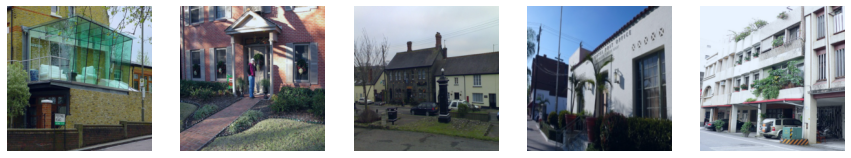

In [5]:
print("ResNet\n")

print("The leftmost image is the picked image, the other 4 is its nearest neighbors")
fig0, ax0 = plt.subplots(1, 5)
fig0.set_figwidth(15)
for i, index in enumerate(indices0[0]):
    image = np.moveaxis(all_data[index], 0, -1)
    image = (image - image.min()) / (image.max() - image.min())
    ax0[i].axis("off")
    ax0[i].imshow(image)
plt.show()

print("The leftmost image is the picked image, the other 4 is its nearest neighbors")
fig1, ax1 = plt.subplots(1, 5)
fig1.set_figwidth(15)
for i, index in enumerate(indices1[0]):
    image = np.moveaxis(all_data[index], 0, -1)
    image = (image - image.min()) / (image.max() - image.min())
    ax1[i].axis("off")
    ax1[i].imshow(image)
plt.show()

print("The leftmost image is the picked image, the other 4 is its nearest neighbors")
fig2, ax2 = plt.subplots(1, 5)
fig2.set_figwidth(15)
for i, index in enumerate(indices2[0]):
    image = np.moveaxis(all_data[index], 0, -1)
    image = (image - image.min()) / (image.max() - image.min())
    ax2[i].axis("off")
    ax2[i].imshow(image)
plt.show()

## 5.2 t-SNE visualization of intermediate features (7pts)
We can also visualize how the feature representations specialize for different classes. Take 1000 random images from the test set of PASCAL, and extract caffenet (scratch) fc7 features from those images. Compute a 2D t-SNE projection of the features, and plot them with each feature color coded by the GT class of the corresponding image. If multiple objects are active in that image, compute the color as the ”mean” color of the different classes active in that image. Legend the graph with the colors for each object class.

In [31]:
# plot t-SNE here
model = CaffeNet().to('cuda')
model.load_state_dict(torch.load("models/q2_50"))
model.eval()

test_loader = utils.get_data_loader('voc', train=False, batch_size=50, split='test')
all_features = None
all_targets = None
counter = 0
for batch_idx, (data, target, wgt) in enumerate(test_loader):
    if counter == 20:
        break
    data, target, wgt = data.to('cuda'), target.to('cuda'), wgt.to('cuda')
    output = model(data)
    if all_features is None:
        all_features = output.detach().cpu().numpy()
    else:
        all_features = np.concatenate((all_features, output.detach().cpu().numpy()), axis=0)
    if all_targets is None:
         all_targets = target.detach().cpu().numpy()
    else:
         all_targets = np.concatenate((all_targets, target.detach().cpu().numpy()), axis=0)
    counter += 1

In [16]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

colors = []
for i in range(20):
    color = list(np.random.choice(range(256), size=3))
    colors.append(color)

features_embedded = TSNE(n_components=2).fit_transform(all_features)

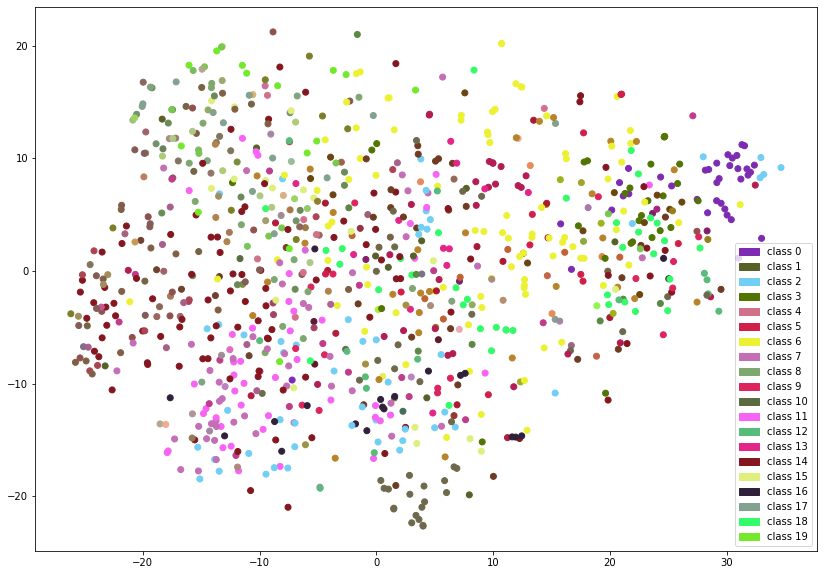

In [51]:
c = np.array(colors)
mean_cs = []
for i in range(1000):
    multi_c = c[np.where(all_targets[i, :].astype(np.int)==1)]
    mean_c = np.mean(multi_c, axis=0)
    mean_cs.append(mean_c.astype(np.int))

plt.figure(figsize=(14, 10))
import matplotlib.patches as mpatches
handles = []
for i in range(c.shape[0]):
    patch = mpatches.Patch(color=c[i] / 255, label="class " + str(i))
    handles.append(patch)
plt.legend(handles=handles)
    
c = np.array(mean_cs)
plt.scatter(features_embedded[:, 0], features_embedded[:, 1], c=c/255)
plt.show()

## 5.3 Are some classes harder? (6pts)
Show the per-class performance of your caffenet (scratch) and ResNet (finetuned) models. Try to explain, by observing examples from the dataset, why some classes are harder or easier than the others (consider the easiest and hardest class). Do some classes see large gains due to pre-training? Can you explain why that might happen?

**YOUR ANSWER HERE**

We can see that the airplane class is easy, since the airplanes are usually in the center of the image, and the background is distinguishable from the plane. There is very little room to misclassify.
However, for the pottedplant class, the sizes and shapes of the plants are very different, so it is quite hard to classify this class.

Some classes, like class 16 (Sheep), see large gains due to pre-training (from 0.2281 to 0.8272).
This might be becasue we don't really have a lot of sheep images in our dataset, but we have a lot of sheep images in the ImageNet dataset.

In [65]:
class CaffeNet_(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(256 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 20)
        self.dropout = nn.Dropout(p=0.5) 
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        flat_x = x.view(-1, 256 * 5 * 5)
        out = self.fc1(flat_x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out


class PretrainedResNet_(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 20)
        
    def forward(self, x):
        return self.resnet(x)
    
model1, model2 = CaffeNet_().to('cuda'), PretrainedResNet_().to('cuda')
model1.load_state_dict(torch.load("models/q2_50"))
model2.load_state_dict(torch.load("models/q4_10"))
model1.eval()
model2.eval()

test_loader = utils.get_data_loader('voc', train=False, batch_size=32, split='test')
ap1, map1 = utils.eval_dataset_map(model1, 'cuda', test_loader)
ap2, map2 = utils.eval_dataset_map(model2, 'cuda', test_loader)

In [63]:
print("caffenet")
for i, ap in enumerate(ap1):
    print("class " + str(i) + ":", ap)

print("resnet")
for i, ap in enumerate(ap2):
    print("class " + str(i) + ":", ap)

caffenet
class 0: 0.6571594368211714
class 1: 0.4146887133450841
class 2: 0.3912622672351793
class 3: 0.4518777118809009
class 4: 0.08013075429068757
class 5: 0.38600263386583133
class 6: 0.6242862185129479
class 7: 0.41953464397269563
class 8: 0.28765640253403024
class 9: 0.1521166953334916
class 10: 0.27783947389837693
class 11: 0.3041652753368963
class 12: 0.6206574697871048
class 13: 0.4432827291334196
class 14: 0.7761796835850486
class 15: 0.23661580814430566
class 16: 0.22809223481213398
class 17: 0.3246888150772234
class 18: 0.5504456105185601
class 19: 0.37415340681149795
resnet
class 0: 0.9419235037056286
class 1: 0.795997299716794
class 2: 0.9084771841265284
class 3: 0.7871659758602396
class 4: 0.3088018903481415
class 5: 0.7404690874522255
class 6: 0.8812303927242877
class 7: 0.8967646592792092
class 8: 0.4907394713333879
class 9: 0.5324915842399371
class 10: 0.5192030102788457
class 11: 0.8199904353538435
class 12: 0.47276066935745226
class 13: 0.7351923130568266
class 14: 

In [5]:
test_loader = utils.get_data_loader('voc', train=False, batch_size=1, split='test')
easy_images = []
hard_images = []
counter_easy, counter_hard = 0, 0
for batch_idx, (data, target, wgt) in enumerate(test_loader):
    data, target, wgt = data.to('cuda'), target.to('cuda'), wgt.to('cuda')
    if len(easy_images) < 5:
        if target[0, 0].item() == 1.:
            easy_images.append(data[0].cpu().detach().numpy())
    
    if len(hard_images) < 5:
        if target[0, 15].item() == 1.:
            hard_images.append(data[0].cpu().detach().numpy())
          
    if len(easy_images) >= 5 and len(hard_images) >= 5:  
        break


Easy Examples


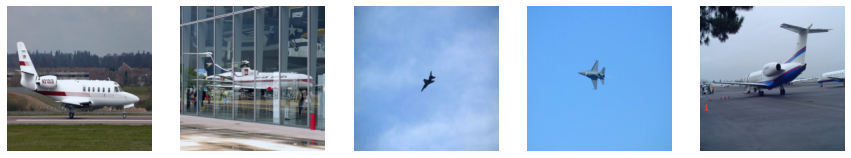

Hard Examples


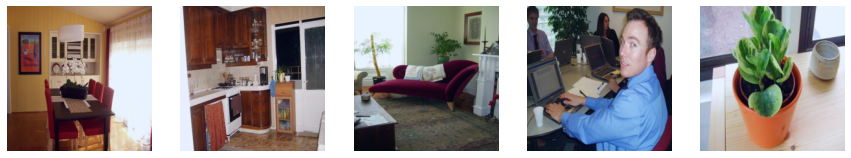

In [8]:
print("Easy Examples")
fig4, ax4 = plt.subplots(1, 5)
fig4.set_figwidth(15)
for i in range(5):  
    image = np.moveaxis(easy_images[i], 0, -1)
    image = (image - image.min()) / (image.max() - image.min())
    ax4[i].axis("off")
    ax4[i].imshow(image)
plt.show()

print("Hard Examples")
fig5, ax5 = plt.subplots(1, 5)
fig5.set_figwidth(15)
for i in range(5):  
    image = np.moveaxis(hard_images[i], 0, -1)
    image = (image - image.min()) / (image.max() - image.min())
    ax5[i].axis("off")
    ax5[i].imshow(image)
plt.show()